In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
torch.__version__, torchvision.__version__

('1.13.1', '0.14.1')

In [3]:
# Get dataset: FashionMNIST

In [4]:
train_data = datasets.FashionMNIST(
    root="data", # where to put downloaded data
    train=True, # Get training data
    download=True,
    transform=ToTensor(), # must be from torchvision.transforms. Raw images come in PIL format, so want them in tensors
    target_transform=None # how you'd like to transform the y
)

test_data = datasets.FashionMNIST(
    root="data", 
    train=False, # Get Test data
    download=True,
    transform=ToTensor()
)

In [5]:
X, y = train_data[123]
X.shape, y

(torch.Size([1, 28, 28]), 2)

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

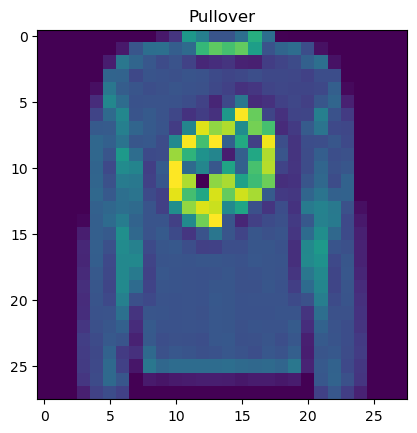

In [8]:
plt.imshow(X.squeeze())
plt.title(class_names[y]);

In [9]:
# Prepare dataloader with torch.utils.data.DataLoader, for training and inference.
# It turns a large dataset into an Iterable of smaller mini-batches.

# Why use mini-batches?
# 1. It's more computationally efficient
# 2. Grad descent is performed more often per epoch (once per mini-batch vs once per whole dataset)
# so it gives the model more opportunities to improve.

# Typical mini-batch size (of number of samples): 32, 64, 128, etc.

In [10]:
from torch.utils.data import DataLoader

In [11]:
BATCH_SIZE = 64

In [12]:
train_dataloader = DataLoader(
    train_data, # Turn dataset to iterable
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle data every epoch over all batches
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [13]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x176adb2c220>,
 <torch.utils.data.dataloader.DataLoader at 0x176adad1370>)

In [14]:
print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 938 batches of 64
Test dataloader: 157 batches of 64


In [15]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Baseline model0

In [17]:
# Need to flatten 2D images to 1D array
flatten_model = nn.Flatten()

In [18]:
x0, y0 = next(iter(train_dataloader))
x0[10].shape, flatten_model(x0[10]).shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [19]:
import torchmetrics

In [20]:
torch_acc = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names))
torch_acc_gpu = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names)).to("cuda")

In [21]:
def accuracy_fn(y_true, y_pred):
    return torch_acc(y_pred, y_true).item()

In [22]:
def accuracy_fn_gpu(y_true, y_pred):
    return torch_acc_gpu(y_pred, y_true).item()

In [23]:
# Define a timer to measure running times on CPU vs on GPU

In [24]:
from timeit import default_timer as timer

In [25]:
def print_train_time(start: float, end: float, device: torch.device=None):
    delta = end - start
    print(f"Training time on {device}: {delta:.4f} seconds")
    return delta

In [26]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layers(x)

In [27]:
torch.manual_seed(12)

model0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))

model0.to("cpu")

# Set up loss function, optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)

In [28]:
# Training loop

In [29]:
from tqdm.auto import tqdm

In [30]:
torch.manual_seed(12)

train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    
    print(f"Epoch: {epoch}\n-----")
    
    # Training
    train_loss = 0.0
    
    # In each epoch, loop through all training batches
    for batch, (X, y) in enumerate(train_dataloader):
        
        model0.train()
        
        y_pred = model0(X)
        
        # Loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"At {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
    # At the end of training in each epoch
    train_loss /= len(train_dataloader) # How many batches? Ans: len(train_dataloader)
    
    # Testing
    test_loss = 0.0
    test_acc = 0.0
    
    model0.eval()
    
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model0(X)
            
            test_loss += loss_fn(test_pred, y).item()
            
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.4f}\n")

train_time_end_on_cpu = timer()

train_time_model0 = print_train_time(
    train_time_start_on_cpu, 
    train_time_end_on_cpu,
    device=str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
At 0/60000 samples
At 25600/60000 samples
At 51200/60000 samples

Train loss: 0.6376 | Test loss: 0.54521, Test acc: 0.8037

Epoch: 1
-----
At 0/60000 samples
At 25600/60000 samples
At 51200/60000 samples

Train loss: 0.4857 | Test loss: 0.56256, Test acc: 0.7894

Epoch: 2
-----
At 0/60000 samples
At 25600/60000 samples
At 51200/60000 samples

Train loss: 0.4619 | Test loss: 0.49341, Test acc: 0.8172

Training time on cpu: 18.9655 seconds


In [31]:
# Inference

In [32]:
def eval_model(
    model: torch.nn.Module, 
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device="cpu"
) -> dict:
    loss = 0.0
    acc = 0.0
    
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    dict_out = {
        "model_name": model.__class__.__name__,
        "model_loss": loss,
        "model_acc": acc
    }
    
    return dict_out

In [33]:
model0_metrics = eval_model(model0, test_dataloader, loss_fn, accuracy_fn)
model0_metrics

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.49340755715491663,
 'model_acc': 0.8171775477707006}

# Improved Model1

In [34]:
# Add nonlinearlity

In [35]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [36]:
torch.manual_seed(123)

model1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [37]:
# Define training step per epoch

def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device=device
):
    
    train_loss = 0.0
    train_acc = 0.0
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        y_pred_label = y_pred.argmax(dim=1)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred_label)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    train_loss /= len(data_loader) # numBatches per epoch
    train_acc /= len(data_loader)
    
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f}")

In [38]:
# Define test step per epoch

def test_step(model, data_loader, loss_fn, accuracy_fn, device=device):
    test_loss = 0.0
    test_acc = 0.0
    
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            test_pred_label = test_pred.argmax(dim=1)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred_label)
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}")

In [39]:
torch.manual_seed(123)

train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model1, train_dataloader, loss_fn, optimizer, accuracy_fn_gpu)
    test_step(model1, test_dataloader, loss_fn, accuracy_fn_gpu)

train_time_end_on_gpu = timer()

train_time_model1 = print_train_time(
    train_time_start_on_gpu, 
    train_time_end_on_gpu,
    device=str(next(model1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 0.7186 | Train accuracy: 0.75
Test loss: 0.5397 | Test accuracy: 0.81
Epoch: 1
-----
Train loss: 0.4884 | Train accuracy: 0.83
Test loss: 0.4855 | Test accuracy: 0.83
Epoch: 2
-----
Train loss: 0.4539 | Train accuracy: 0.84
Test loss: 0.4828 | Test accuracy: 0.83
Training time on cuda:0: 23.4268 seconds


In [40]:
torch.manual_seed(123)

model1_results = eval_model(
    model=model1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn_gpu, device=device)
model1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4827734373367516,
 'model_acc': 0.8296178343949044}

# Convolutional Neural Network model

In [41]:
# Typical CNN structure:
# Input layer
# [Convolutional layer -> activation layer -> pooling layer] * multipleTimes
# Output layer

In [42]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, 
                out_channels=hidden_units, 
                kernel_size=3, 
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # In Pooing, default stride = kernel size
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*7*7, # Cf. algebraic relation between kernel_size/stride/pooling
                out_features=output_shape)
        )
    
    def forward(self, x:torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [43]:
# Conv2d

# nn.Conv2d() expects a 4-dim tensor of shape 
# [batch_size, channels, height, width]

# Note: when nn.Conv2d() is in the middle of the network (i.e. not directly connected to input),
# the "channels" = num of hidden units

In [44]:
# MaxPool2d

# Every layer in NNet is trying to compress data from higher to lower dimensional space.
# nn.MaxPool2d() takes the max from a portion of a tensor and disregard the rest. 
# (It's the same story for nn.Conv2d(), except that Conv2d performs a convolutional operation on data)

In [45]:
torch.manual_seed(1234)

model2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [46]:
# Loss and Optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

In [47]:
torch.manual_seed(1234)

train_time_start_model2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(
        model=model2, 
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn_gpu,
        device=device)
    
    test_step(
        model=model2,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn_gpu,
        device=device)

train_time_end_model2 = timer()

totoal_train_time_model2 = print_train_time(
    start=train_time_start_model2,
    end=train_time_end_model2,
    device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 0.7759 | Train accuracy: 0.72
Test loss: 0.5134 | Test accuracy: 0.81
Epoch: 1
-----
Train loss: 0.4077 | Train accuracy: 0.85
Test loss: 0.3886 | Test accuracy: 0.86
Epoch: 2
-----
Train loss: 0.3589 | Train accuracy: 0.87
Test loss: 0.3864 | Test accuracy: 0.86
Training time on cuda: 23.6096 seconds


In [48]:
model2_results = eval_model(
    model=model2, 
    data_loader=test_dataloader, 
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn_gpu,
    device=device
)
model2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.38635989121950354,
 'model_acc': 0.8615644904458599}

In [49]:
import pandas as pd

In [50]:
df_model_comparison = pd.DataFrame([model0_metrics, model1_results, model2_results])
df_model_comparison["training time"] = [19.30, 22.70, 20.41]
df_model_comparison

,model_name,model_loss,model_acc,training time
0,FashionMNISTModelV0,0.493408,0.817178,19.30
1,FashionMNISTModelV1,0.482773,0.829618,22.70
2,FashionMNISTModelV2,0.386360,0.861564,20.41


# Inference

In [51]:
def predict(model:torch.nn.Module, data:list, device:torch.device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [52]:
import random

In [53]:
random.seed(123)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [54]:
test_samples[0].shape, test_labels[0]

(torch.Size([1, 28, 28]), 1)

In [55]:
pred_probs = predict(model2, test_samples)
pred_probs[:3], pred_probs[:3].shape

(tensor([[3.5489e-05, 9.9390e-01, 7.8296e-07, 5.8965e-03, 5.4994e-05, 1.1500e-05,
          2.9393e-05, 2.7045e-06, 6.1195e-05, 4.1380e-06],
         [7.0665e-05, 1.1212e-07, 4.3199e-06, 5.4362e-05, 3.7581e-07, 9.9935e-01,
          1.6142e-06, 2.5152e-04, 1.0287e-04, 1.6252e-04],
         [9.9203e-01, 4.7233e-07, 3.7646e-04, 1.5185e-04, 5.3553e-06, 5.4059e-09,
          7.3976e-03, 4.8178e-09, 3.7637e-05, 7.6312e-09]]),
 torch.Size([3, 10]))

In [56]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([1, 5, 0, 3, 3, 6, 0, 9, 9]), [1, 5, 0, 3, 3, 6, 0, 9, 9])

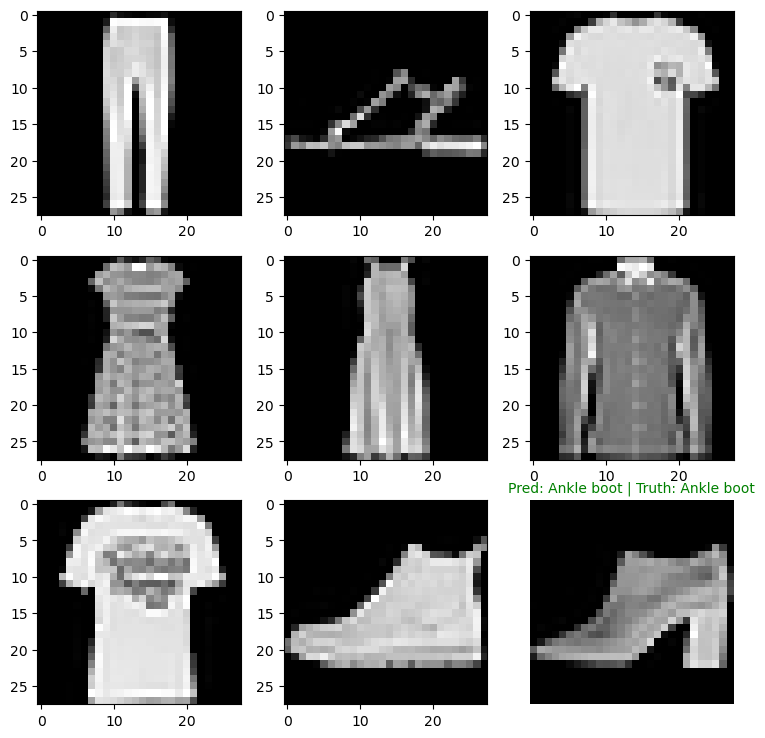

In [57]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if correct
else:
    plt.title(title_text, fontsize=10, c="r") # red text if wrong
plt.axis(False);

# Confusion matrix

In [58]:
y_preds = []

model2.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Inference on test data"):
        X, y = X.to(device), y.to(device)
        y_logit = model2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_preds = torch.cat(y_preds)

Inference on test data:   0%|          | 0/157 [00:00<?, ?it/s]

In [59]:
import mlxtend
mlxtend.__version__

'0.21.0'

In [60]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [61]:
conf_mat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")

In [62]:
conf_mat(preds=y_preds, target=test_data.targets)

tensor([[912,   2,  10,  36,   3,   1,  25,   0,  11,   0],
        [  5, 962,   0,  25,   3,   0,   2,   0,   3,   0],
        [ 24,   0, 838,   9,  89,   0,  38,   0,   2,   0],
        [ 51,   1,  10, 894,  23,   0,  18,   0,   3,   0],
        [  3,   1, 102,  38, 783,   0,  67,   0,   6,   0],
        [  0,   0,   0,   1,   0, 990,   0,   3,   1,   5],
        [257,   1,  99,  31,  92,   0, 505,   0,  15,   0],
        [  0,   0,   0,   0,   0, 117,   0, 778,   0, 105],
        [  3,   1,   7,   3,   4,   6,   4,   0, 972,   0],
        [  0,   0,   0,   0,   0,  14,   0,   8,   0, 978]])

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
conf_mat = confusion_matrix(y_true=test_data.targets.numpy(), y_pred=y_preds.numpy())

In [65]:
conf_mat

array([[912,   2,  10,  36,   3,   1,  25,   0,  11,   0],
       [  5, 962,   0,  25,   3,   0,   2,   0,   3,   0],
       [ 24,   0, 838,   9,  89,   0,  38,   0,   2,   0],
       [ 51,   1,  10, 894,  23,   0,  18,   0,   3,   0],
       [  3,   1, 102,  38, 783,   0,  67,   0,   6,   0],
       [  0,   0,   0,   1,   0, 990,   0,   3,   1,   5],
       [257,   1,  99,  31,  92,   0, 505,   0,  15,   0],
       [  0,   0,   0,   0,   0, 117,   0, 778,   0, 105],
       [  3,   1,   7,   3,   4,   6,   4,   0, 972,   0],
       [  0,   0,   0,   0,   0,  14,   0,   8,   0, 978]], dtype=int64)

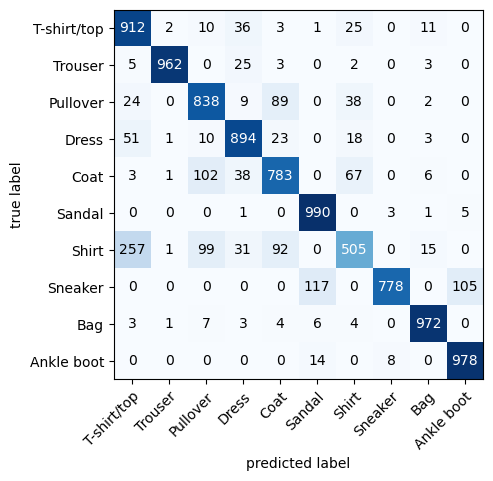

In [66]:
fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat,
    class_names=class_names
)

# Save/Load model

In [67]:
from pathlib import Path

In [68]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_cnn.pt"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_cnn.pt


In [69]:
loaded_model2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)

loaded_model2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model2 = loaded_model2.to(device)

In [70]:
torch.manual_seed(12345)

loaded_model2_results = eval_model(
    model=loaded_model2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn_gpu,
    device=device
)

loaded_model2_results, model2_results

({'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.38635989121950354,
  'model_acc': 0.8615644904458599},
 {'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.38635989121950354,
  'model_acc': 0.8615644904458599})

In [71]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model2_results["model_loss"]), 
              torch.tensor(loaded_model2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)